In [1]:
import os
import sys
import json
import time
import math
import gspread
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.lines import Line2D
import matplotlib.ticker as mticker
import seaborn as sns
from scipy import integrate, signal, stats, fftpack
from glob import glob
from datetime import date
import mne
from mne.time_frequency import tfr_array_morlet

In [2]:
sys.path.append(r'C:\Users\lesliec\code')

In [3]:
from tbd_eeg.tbd_eeg.data_analysis.eegutils import EEGexp
from tbd_eeg.tbd_eeg.data_analysis.Utilities.utilities import get_stim_events, get_evoked_traces, find_nearest_ind

from PCIst.PCIst.pci_st import calc_PCIst, dimensionality_reduction

In [4]:
%matplotlib notebook

#### Functions

In [5]:
def get_stim_event_inds(stim_table, stim_type, stim_param, sweep, trials='resting'):
    if trials == 'resting':
        return stim_table[
            (stim_table['stim_type'] == stim_type) &
            (stim_table['parameter'] == stim_param) &
            (stim_table['sweep'] == sweep) &
            (stim_table['good'] == True) &
            (stim_table['resting_trial'] == True)
        ].index.values
    elif trials == 'running':
        return stim_table[
            (stim_table['stim_type'] == stim_type) &
            (stim_table['parameter'] == stim_param) &
            (stim_table['sweep'] == sweep) &
            (stim_table['good'] == True) &
            (stim_table['resting_trial'] == False)
        ].index.values
    else:
        return stim_table[
            (stim_table['stim_type'] == stim_type) &
            (stim_table['parameter'] == stim_param) &
            (stim_table['sweep'] == sweep) &
            (stim_table['good'] == True)
        ].index.values

#### Load Zap_Zip-log_exp to get metadata for experiments

In [6]:
_gc = gspread.service_account() # need a key file to access the account
_sh = _gc.open('Zap_Zip-log_exp') # open the spreadsheet
_df = pd.DataFrame(_sh.sheet1.get()) # load the first worksheet
zzmetadata = _df.T.set_index(0).T # put it in a nicely formatted dataframe

In [7]:
state_colors = {
    'awake': (120/255, 156/255, 74/255),
    'anesthetized': (130/255, 122/255, 163/255),
    'recovery': (93/255, 167/255, 229/255)
}

In [8]:
layers = ['1', '2/3', '4', '5', '6a', '6b']
colorspace = np.linspace(0, 1, len(layers))
layer_colors = {li: cm.rainbow(xi) for (li, xi) in zip(layers, colorspace)}

### Load subjects list from .json file

In [10]:
with open(r'C:\Users\lesliec\OneDrive - Allen Institute\data\all_iso_subjects.json') as subjects_file:
    multi_sub_dict = json.load(subjects_file)

In [11]:
for group, group_subs in multi_sub_dict.items():
    print(group)
    print('')
    for mouse_num, mdata in group_subs.items():
        print(' {}'.format(mouse_num))
        mdata['exp'] = EEGexp(mdata['data_loc'], preprocess=False, make_stim_csv=False)
        print('')

MOs_superficial

 521885
Experiment type: electrical stimulation
SomnoSuite log file not found.

 521886
Experiment type: electrical stimulation
SomnoSuite log file not found.

 521887
Experiment type: electrical stimulation
SomnoSuite log file not found.

 543393
Experiment type: electrical stimulation
SomnoSuite log file not found.

 543394
Experiment type: electrical stimulation
SomnoSuite log file not found.

 546655
Experiment type: electrical and sensory stimulation

 575102
Experiment type: electrical and sensory stimulation
SomnoSuite log file not found.

 571619
Experiment type: electrical stimulation
SomnoSuite log file not found.

MOs_deep

 551399
Experiment type: electrical stimulation
SomnoSuite log file not found.

 551397
Experiment type: electrical and sensory stimulation
Body camera file not found.
Pupil camera file not found.

 569062
Experiment type: electrical and sensory stimulation

 569068
Experiment type: electrical and sensory stimulation

 569069
Experiment t

In [9]:
# plotsdir = r'C:\Users\lesliec\OneDrive - Allen Institute\data\plots'
plotsdir = r'C:\Users\lesliec\OneDrive - Allen Institute\data\plots\manuscript_figs\LFP_analyses'

### Load LFP traces

In [13]:
## parameters ##
chtrials = 'resting' # choose: 'resting', 'running', or 'all'
test_states = ['awake', 'anesthetized']
current_level = ['low', 'medium', 'high']
cortex = ['MO', 'ACA', 'SS', 'VIS']

### Test single subject

In [14]:
group = 'MOs_deep'
mouse_num = '569073'
mdata = multi_sub_dict[group][mouse_num]

## Grab exp metadata from Zap_Zip-log_exp ##
exp_meta = zzmetadata[(
    (zzmetadata['mouse_name'].str.contains(mdata['exp'].mouse)) &
    (zzmetadata['exp_name'].str.contains(os.path.basename(os.path.dirname(mdata['exp'].experiment_folder))))
)].squeeze()
currentstr = exp_meta['Current (uA)'].replace(' ','')
currents_list = []
for char in currentstr.split('/'):
    if char.isdecimal():
        currents_list.append(char)
if len(currents_list) > 1:
    PCI_stim_amp = currents_list[1]
elif len(currents_list) == 1:
    PCI_stim_amp = currents_list[0]
else:
    print('No stim current listed in Zap_Zip-log_exp')
    
## Load stim log ##
stim_log = pd.read_csv(mdata['exp'].stimulus_log_file)
stim_log = stim_log.astype({'parameter': str})

## Load LFP info and traces ##
evoked_data_folder = os.path.join(mdata['exp'].data_folder, 'evoked_data')
LFPinfo_filename = os.path.join(evoked_data_folder, 'evokedLFPinfo.json')
with open(LFPinfo_filename) as info_file:
    LFPinfo = json.load(info_file)
LFP_event_ts = np.load(os.path.join(evoked_data_folder, 'evokedLFPtimestamps.npy'))
LFP_traces = {}
for region in LFPinfo.keys():
    LFP_traces[region] = {}
    allLFPtraces = np.load(os.path.join(evoked_data_folder, region + '_evokedLFPtraces.npy'))
    for leveli, parami in zip(current_level, currents_list):
        LFP_traces[region][leveli] = {}
        for statei in test_states:
            sweeps = mdata['states'][statei]
            if sweeps:
                state_event_inds = []
                for sweepi in sweeps:
                    eventinds = get_stim_event_inds(stim_log, 'biphasic', parami, sweepi, trials=chtrials)
                    if len(eventinds) == 0:
                        continue
                    state_event_inds.append(eventinds)
                state_event_inds = np.concatenate(state_event_inds)
                ## Get evoked LFP traces ##
                LFP_traces[region][leveli][statei] = allLFPtraces[:, :, state_event_inds]
ctx_regions = [k for k in LFP_traces.keys() if k in cortex]
print(ctx_regions)

['MO', 'ACA', 'SS', 'VIS']


### Plot chs across all layers (imshow)

<IPython.core.display.Javascript object>


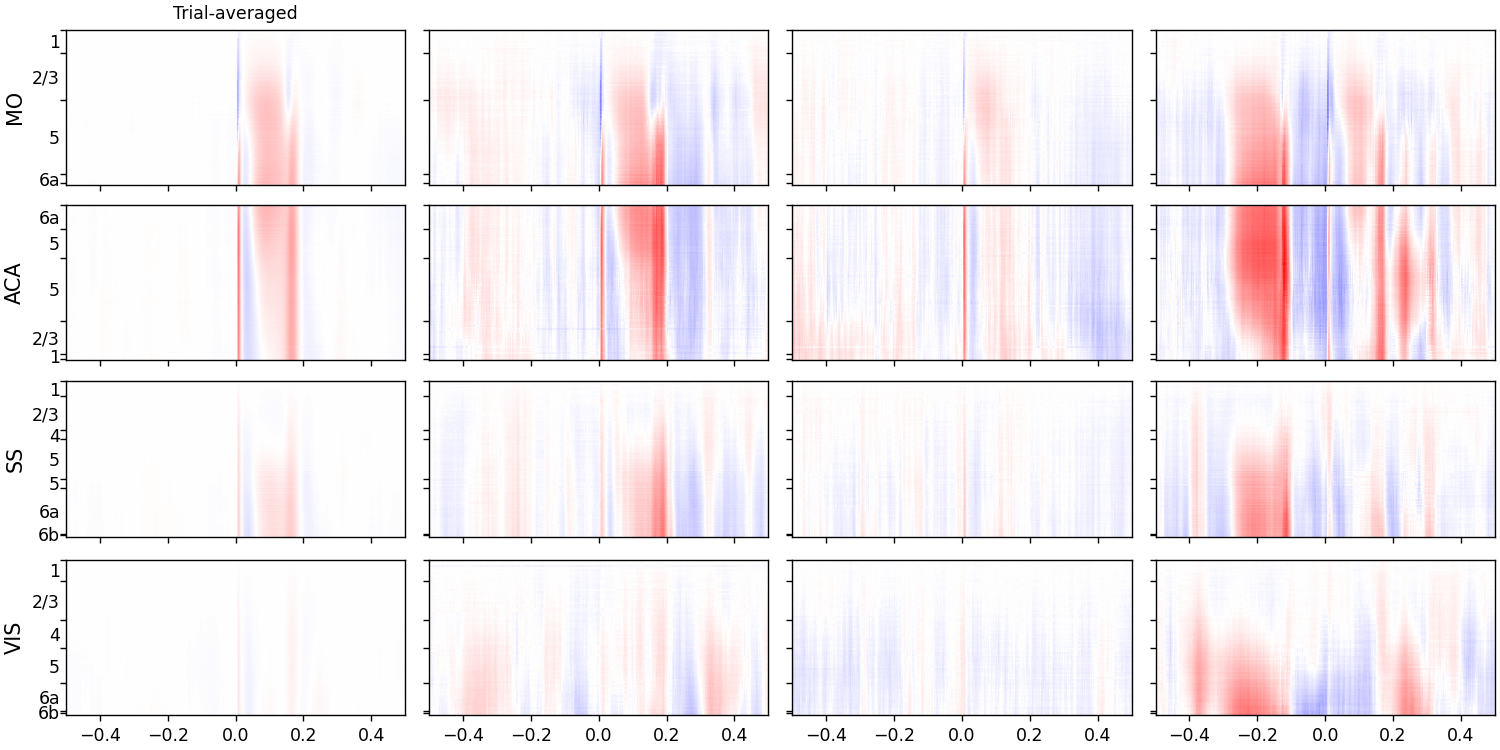

Text(0.5, 1.0, 'Trial-averaged')

In [16]:
plevel = 'medium'
pstate = 'awake'
pwin = [-0.5, 0.5]
vlevel = 1200
# ptrials = np.sort(np.random.choice(np.arange(LFP_traces['MO'][plevel][pstate].shape[2]), 3, replace=False))
ptrials = np.array([3, 25, 67])

pinds = np.nonzero((LFP_event_ts >= pwin[0]) & (LFP_event_ts <= pwin[1]))

fig, axs = plt.subplots(len(ctx_regions), len(ptrials) + 1, figsize=(12,6), sharex=True, constrained_layout=True)
for rowi, regi in enumerate(ctx_regions):
    traces = LFP_traces[regi][plevel][pstate]
    ch_areas = LFPinfo[regi]['ch_areas']
    ## Find layer borders ##
    borders = [False]
    labels = [ch_areas[0][[i for i, c in enumerate(ch_areas[0]) if c.isdigit()][0]:]]
    for ii in range(1, len(ch_areas)):
        if ch_areas[ii] == ch_areas[ii-1]:
            borders.append(True)
        else:
            borders.append(False)
            labels.append(ch_areas[ii][[i for i, c in enumerate(ch_areas[ii]) if c.isdigit()][0]:])
    borders[-1] = False
    borderlocs = np.nonzero(np.invert(borders))[0]
    ## Plot ##
    axs[rowi,0].imshow(
        np.mean(traces, axis=2)[pinds,:].T, cmap='bwr', interpolation='none', aspect='auto', origin='upper',
        vmin=-vlevel, vmax=vlevel, extent=[pwin[0], pwin[1], traces.shape[1], 0]
    )
    axs[rowi,0].set_yticks(borderlocs)
    axs[rowi,0].set_yticklabels('')
    axs[rowi,0].set_yticks(borderlocs[:-1] + np.diff(borderlocs)/2, minor=True)
    axs[rowi,0].set_yticklabels(labels, minor=True, fontsize=10)
    axs[rowi,0].tick_params(which='minor', length=0)
    axs[rowi,0].set_ylabel(regi, fontsize=12)
    for coli, triali in enumerate(ptrials):
        axs[rowi,coli+1].imshow(
            traces[pinds,:,triali].T, cmap='bwr', interpolation='none', aspect='auto', origin='upper',
            vmin=-vlevel, vmax=vlevel, extent=[pwin[0], pwin[1], traces.shape[1], 0]
        )
        axs[rowi,coli+1].set_yticks(borderlocs)
        axs[rowi,coli+1].set_yticklabels('')
axs[0,0].set_title('Trial-averaged')

### Plot average trace for each layer and all layers average

<IPython.core.display.Javascript object>


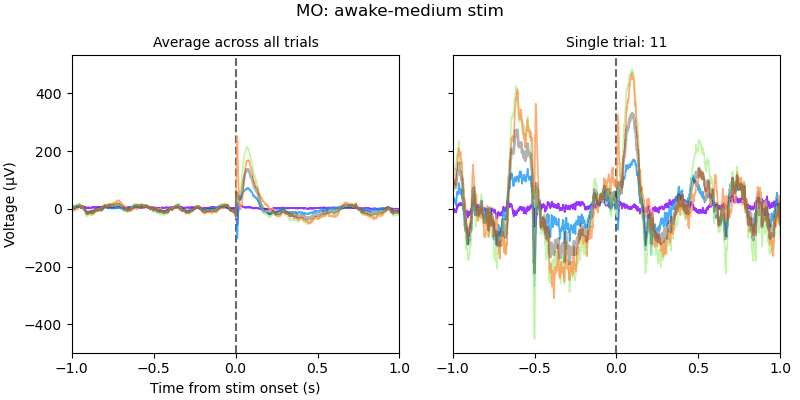

Text(0.5, 0.98, 'MO: awake-medium stim')

In [15]:
plevel = 'medium'
pstate = 'awake'
regi = 'MO'
triali = 11
pwin = [-1.0, 1.0]

traces = LFP_traces[regi][plevel][pstate]
avgtraces = np.mean(LFP_traces[regi][plevel][pstate], axis=2)
ch_areas = np.array(LFPinfo[regi]['ch_areas'])
# layer_mask = np.array([False if '1' in x else True for x in ch_areas])

fig, axs = plt.subplots(1, 2, figsize=(8,4), sharex=True, sharey=True, constrained_layout=True)
axs[0].axvline(0, color='k', linestyle='dashed', alpha=0.6)
axs[1].axvline(0, color='k', linestyle='dashed', alpha=0.6)
for layeri in np.unique(ch_areas):
    lnum = layeri[[i for i, c in enumerate(layeri) if c.isdigit()][0]:]
    lmask = ch_areas == layeri
    axs[0].plot(LFP_event_ts, np.mean(avgtraces[:, lmask], axis=1), color=layer_colors[lnum], linewidth=1.2, alpha=0.8, label=lnum)
    axs[1].plot(LFP_event_ts, np.mean(traces[:, lmask, triali], axis=1), color=layer_colors[lnum], linewidth=1.2, alpha=0.8)
axs[0].plot(LFP_event_ts, np.mean(avgtraces, axis=1), color='k', linewidth=2, alpha=0.3, label='all')
axs[1].plot(LFP_event_ts, np.mean(traces[:, :, triali], axis=1), color='k', linewidth=2, alpha=0.3, label='all')
# axs[0].legend()
axs[0].set_title('Average across all trials')
axs[1].set_title('Single trial: {:d}'.format(triali))
axs[0].set_ylabel('Voltage (\u03bcV)')
axs[0].set_xlabel('Time from stim onset (s)')
axs[0].set_xlim(pwin)
plt.suptitle('{}: {}-{} stim'.format(regi, pstate, plevel))

<IPython.core.display.Javascript object>


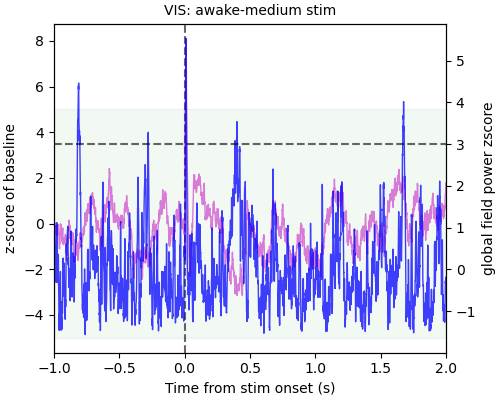

Text(0.5, 1.0, 'VIS: awake-medium stim')

In [22]:
plevel = 'medium'
pstate = 'awake'
regi = 'VIS'
pwin = [-1.0, 2.0]

ch_areas = np.array(LFPinfo[regi]['ch_areas'])
layer_mask = np.array([False if '1' in x else True for x in ch_areas])
ctxtraces = np.mean(LFP_traces[regi][plevel][pstate], axis=2)[:, layer_mask]
globpow = np.std(ctxtraces, axis=1)
z_trace = ((np.mean(ctxtraces, axis=1) - np.mean(np.mean(ctxtraces, axis=1)[LFP_event_ts < 0])) / 
           np.std(np.mean(ctxtraces, axis=1)[LFP_event_ts < 0]))
zglobpow = (globpow - np.mean(globpow[LFP_event_ts < 0])) / np.std(globpow[LFP_event_ts < 0])

fig, ax = plt.subplots(figsize=(5,4), constrained_layout=True)
ax.axvline(0, color='k', linestyle='dashed', alpha=0.6)
ax.axhspan(-5, 5, color='g', alpha=0.05)
ax.plot(LFP_event_ts, z_trace, color='m', linewidth=1, alpha=0.5, label='all')
gfpax = ax.twinx()
gfpax.plot(LFP_event_ts, zglobpow, color='b', linewidth=1, alpha=0.75, label='all')
gfpax.axhline(3, color='k', linestyle='dashed', alpha=0.6)
# axs[0].legend()
ax.set_ylabel('z-score of baseline')
gfpax.set_ylabel('global field power zscore')
ax.set_xlabel('Time from stim onset (s)')
ax.set_xlim(pwin)
ax.set_title('{}: {}-{} stim'.format(regi, pstate, plevel))

<IPython.core.display.Javascript object>


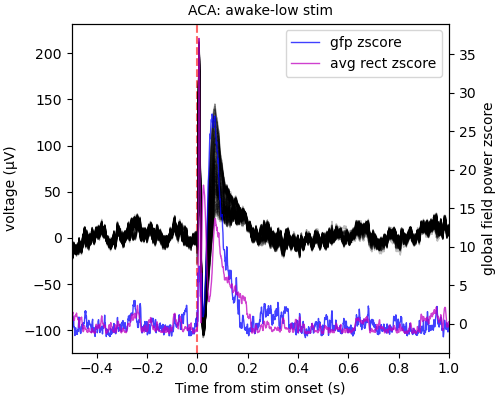

Text(0.5, 1.0, 'ACA: awake-low stim')

In [53]:
plevel = 'low'
pstate = 'awake' # 'awake'
regi = 'ACA'
pwin = [-0.5, 1.0]

ch_areas = np.array(LFPinfo[regi]['ch_areas'])
layer_mask = np.array([False if '1' in x else True for x in ch_areas])
ctxtraces = np.mean(LFP_traces[regi][plevel][pstate], axis=2)[:, layer_mask]
globpow = np.std(ctxtraces, axis=1)
z_trace = ((np.mean(ctxtraces, axis=1) - np.mean(np.mean(ctxtraces, axis=1)[LFP_event_ts < 0])) / 
           np.std(np.mean(ctxtraces, axis=1)[LFP_event_ts < 0]))
zglobpow = (globpow - np.mean(globpow[LFP_event_ts < 0])) / np.std(globpow[LFP_event_ts < 0])


fig, ax = plt.subplots(figsize=(5,4), constrained_layout=True)
ax.axvline(0, color='r', linestyle='dashed', alpha=0.6)
# ax.axhspan(-5, 5, color='g', alpha=0.05)
ax.plot(LFP_event_ts, ctxtraces, color='k', linewidth=1, alpha=0.25)

gfpax = ax.twinx()
gfpax.plot(LFP_event_ts, zglobpow, color='b', linewidth=1, alpha=0.75, label='gfp zscore')

## Rectified average of all ctx signals ##
rectavg = np.mean(np.abs(ctxtraces), axis=1)
zscrect = (rectavg - np.mean(rectavg[LFP_event_ts < 0])) / np.std(rectavg[LFP_event_ts < 0])
gfpax.plot(LFP_event_ts, zscrect, color='m', linewidth=1, alpha=0.75, label='avg rect zscore')

# gfpax.axhline(3, color='k', linestyle='dashed', alpha=0.6)
gfpax.legend()
ax.set_ylabel('voltage (\u03bcV)')
gfpax.set_ylabel('global field power zscore')
ax.set_xlabel('Time from stim onset (s)')
ax.set_xlim(pwin)
ax.set_title('{}: {}-{} stim'.format(regi, pstate, plevel))

In [54]:
zlim = 3
auc_win = [0, 0.6]
aucinds = np.nonzero((LFP_event_ts > auc_win[0]) & (LFP_event_ts < auc_win[1]))[0]
auc = integrate.simps(zscrect[aucinds], LFP_event_ts[aucinds], axis=0, even='last')
print(auc)

1.292658738828077


## Time-frequency analysis

#### Frequency: linear scale

In [27]:
plevel = 'medium'
pstate = 'awake' # 'awake' 'anesthetized'
regi = 'MO'
layeri = '5'

test_freqs = np.arange(2., 81., 3.)
test_ncycles = test_freqs / 5.  # different number of cycle per frequency

ch_areas = np.array(LFPinfo[regi]['ch_areas'])
lmask = np.array([True if layeri in x else False for x in ch_areas])
traces = LFP_traces[regi][plevel][pstate][:, lmask, :]

start = time.time()
power = tfr_array_morlet(traces.T, sfreq=2500/2, freqs=test_freqs, n_cycles=test_ncycles, output='avg_power')
## (n_chans, n_freqs, n_times) ##

## Baseline adjust power  and plot ##
blpower = mne.baseline.rescale(power, LFP_event_ts, (-1.8, -0.5), mode='logratio', copy=True)
end = time.time()
print('Time to analyze: {:.2f} min'.format((end-start)/60))

Applying baseline correction (mode: logratio)
Time to analyze: 0.53 min


<IPython.core.display.Javascript object>


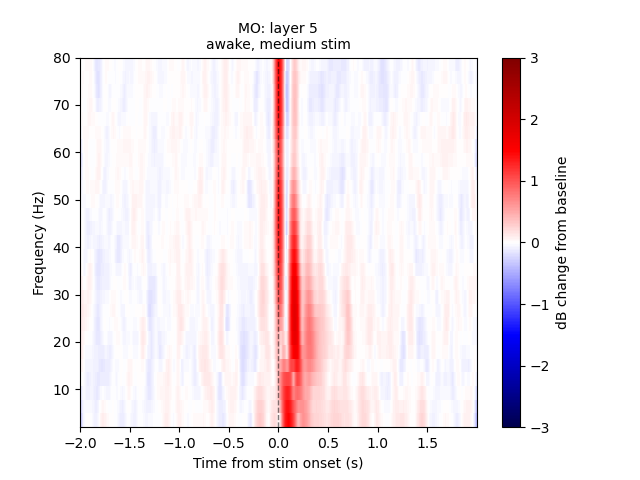

Text(0.5, 1.0, 'MO: layer 5\nawake, medium stim')

In [28]:
fig, ax = plt.subplots()
# im = ax.imshow(
#     np.mean(blpower, axis=0), cmap='seismic', interpolation='none', aspect='auto', origin='lower', vmin=-3, vmax=3,
#     extent=[LFP_event_ts[0], LFP_event_ts[-1], test_freqs[0], test_freqs[-1]]
# )
im = ax.imshow(
    blpower[15,:,:], cmap='seismic', interpolation='none', aspect='auto', origin='lower', vmin=-3, vmax=3,
    extent=[LFP_event_ts[0], LFP_event_ts[-1], test_freqs[0], test_freqs[-1]]
)
ax.axvline(0, color='k', linestyle='dashed', linewidth=1, alpha=0.5)
cbar = fig.colorbar(im)
cbar.set_label('dB change from baseline')
ax.set_ylabel('Frequency (Hz)')
ax.set_xlabel('Time from stim onset (s)')
ax.set_title('{}: layer {}\n{}, {} stim'.format(regi, layeri, pstate, plevel))

Could average across chs before baseline normalization (as suggested by Cohen in textbook), it gives very similar results.

#### Frequency: log scale

Applying baseline correction (mode: logratio)
Time to analyze: 0.49 min


<IPython.core.display.Javascript object>


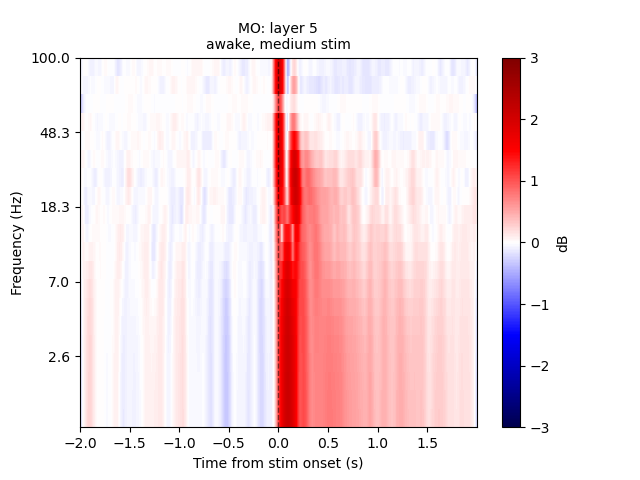

Text(0.5, 1.0, 'MO: layer 5\nawake, medium stim')

In [114]:
plevel = 'medium'
pstate = 'awake'
regi = 'MO'
layeri = '5'

test_freqs = np.logspace(*np.log10([1, 100]), num=20)
test_ncycles = test_freqs / 5.  # different number of cycle per frequency

ch_areas = np.array(LFPinfo[regi]['ch_areas'])
lmask = np.array([True if layeri in x else False for x in ch_areas])
traces = LFP_traces[regi][plevel][pstate][:, lmask, :]

start = time.time()
power = tfr_array_morlet(traces.T, sfreq=2500/2, freqs=test_freqs, n_cycles=test_ncycles, output='avg_power')
## (n_chans, n_freqs, n_times) ##

## Baseline adjust power  and plot ##
mne.baseline.rescale(power, LFP_event_ts, (-1.8, -0.5), mode='logratio', copy=False)
end = time.time()
print('Time to analyze: {:.2f} min'.format((end-start)/60))

fig, ax = plt.subplots()
im = ax.imshow(
    power[42,:,:], cmap='seismic', interpolation='none', aspect='auto', origin='lower', vmin=-3, vmax=3,
    extent=[LFP_event_ts[0], LFP_event_ts[-1], test_freqs[0], test_freqs[-1]]
)
ticks_loc = ax.get_yticks().tolist()
newticklabels = np.concatenate((test_freqs[::4], [test_freqs[-1]]))
ax.yaxis.set_major_locator(mticker.FixedLocator(ticks_loc))
ax.set_yticklabels([label_format.format(x) for x in newticklabels])
ax.axvline(0, color='k', linestyle='dashed', linewidth=1, alpha=0.5)
cbar = fig.colorbar(im)
cbar.set_label('dB change from baseline')
ax.set_ylabel('Frequency (Hz)')
ax.set_xlabel('Time from stim onset (s)')
ax.set_title('{}: layer {}\n{}, {} stim'.format(regi, layeri, pstate, plevel))

#### Testing cycle number (trade-off between time and frequency resolution)

In [81]:
plevel = 'medium'
pstate = 'awake'
regi = 'MO'
layeri = '5'

test_freqs = np.arange(4., 101., 2.)
# test_ncycles = test_freqs / 4.  # different number of cycle per frequency

ch_areas = np.array(LFPinfo[regi]['ch_areas'])
lmask = np.array([True if layeri in x else False for x in ch_areas])
traces = LFP_traces[regi][plevel][pstate][:, lmask, :]

start = time.time()
power3 = tfr_array_morlet(traces.T, sfreq=2500/2, freqs=test_freqs, n_cycles=3, output='avg_power')
power10 = tfr_array_morlet(traces.T, sfreq=2500/2, freqs=test_freqs, n_cycles=10, output='avg_power')
## (n_chans, n_freqs, n_times) ##

## Baseline adjust power  and plot ##
mne.baseline.rescale(power3, LFP_event_ts, (-1.8, -0.5), mode='logratio', copy=False)
mne.baseline.rescale(power10, LFP_event_ts, (-1.8, -0.5), mode='logratio', copy=False)
end = time.time()
print('Time to analyze: {:.2f} min'.format((end-start)/60))

Applying baseline correction (mode: logratio)
Applying baseline correction (mode: logratio)
Time to analyze: 3.30 min


<IPython.core.display.Javascript object>


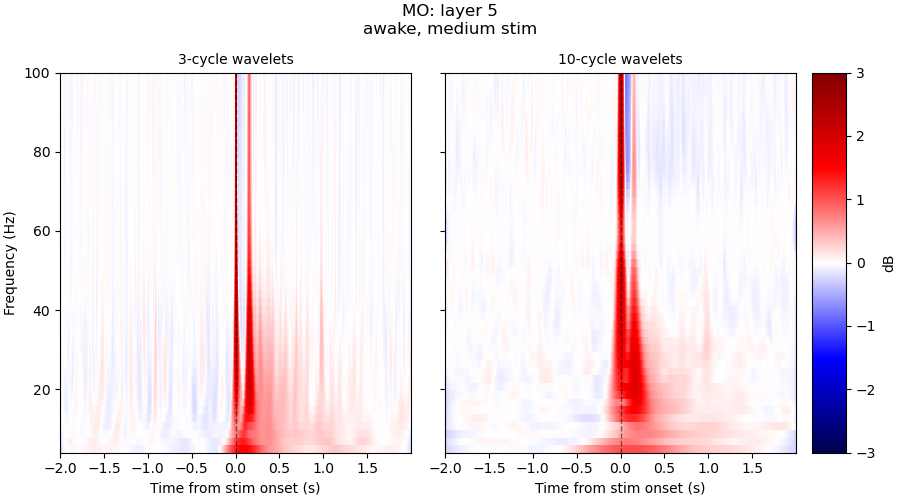

Text(0.5, 0.98, 'MO: layer 5\nawake, medium stim')

In [84]:
fig, axs = plt.subplots(1, 2, figsize=(9,5), sharex=True, sharey=True, constrained_layout=True)
im3 = axs[0].imshow(
    np.mean(power3, axis=0), cmap='seismic', interpolation='none', aspect='auto', origin='lower', vmin=-3, vmax=3,
    extent=[LFP_event_ts[0], LFP_event_ts[-1], test_freqs[0], test_freqs[-1]]
)
axs[0].axvline(0, color='k', linestyle='dashed', linewidth=1, alpha=0.5)
im10 = axs[1].imshow(
    np.mean(power10, axis=0), cmap='seismic', interpolation='none', aspect='auto', origin='lower', vmin=-3, vmax=3,
    extent=[LFP_event_ts[0], LFP_event_ts[-1], test_freqs[0], test_freqs[-1]]
)
axs[1].axvline(0, color='k', linestyle='dashed', linewidth=1, alpha=0.5)
cbar = fig.colorbar(im10)
cbar.set_label('dB change from baseline')
axs[0].set_ylabel('Frequency (Hz)')
axs[0].set_title('3-cycle wavelets')
axs[0].set_xlabel('Time from stim onset (s)')
axs[1].set_xlabel('Time from stim onset (s)')
axs[1].set_title('10-cycle wavelets')
plt.suptitle('{}: layer {}\n{}, {} stim'.format(regi, layeri, pstate, plevel))

## For loading all subjects

In [24]:
response_window = {
    'early': [0.002, 0.025],
    'mid': [0.025, 0.15],
    'late': [0.15, 0.3],
}
zlim = 3

In [25]:
startall = time.time()
all_subs_stats = []
for group, group_subs in multi_sub_dict.items():
    print(group)
    stim_area = group[:2]
    stim_depth = group.split('_')[-1]
    for mouse_num, mdata in group_subs.items():
        print(' {}'.format(mouse_num))
        startsub = time.time()
        evoked_data_folder = os.path.join(mdata['exp'].data_folder, 'evoked_data')
        ## Grab exp metadata from Zap_Zip-log_exp ##
        exp_meta = zzmetadata[(
            (zzmetadata['mouse_name'].str.contains(mdata['exp'].mouse)) &
            (zzmetadata['exp_name'].str.contains(os.path.basename(os.path.dirname(mdata['exp'].experiment_folder))))
        )].squeeze()
        currentstr = exp_meta['Current (uA)'].replace(' ','')
        currents_list = []
        for char in currentstr.split('/'):
            if char.isdecimal():
                currents_list.append(char)
        if len(currents_list) > 1:
            PCI_stim_amp = currents_list[1]
        elif len(currents_list) == 1:
            PCI_stim_amp = currents_list[0]
        else:
            print('No stim current listed in Zap_Zip-log_exp')
        
        ## Load stim log ##
        stim_log = pd.read_csv(mdata['exp'].stimulus_log_file)
        stim_log = stim_log.astype({'parameter': str})
    
        ## Load LFP info and timestamps ##
        LFPinfo_filename = os.path.join(evoked_data_folder, 'evokedLFPinfo.json')
        if not os.path.exists(LFPinfo_filename):
            print('  LFP traces were not created, not analyzing.')
            continue
        with open(LFPinfo_filename) as info_file:
            LFPinfo = json.load(info_file)
        LFP_event_ts = np.load(os.path.join(evoked_data_folder, 'evokedLFPtimestamps.npy'))
        
        ## Load LFP traces ##
        print('  Loading LFP traces for each region...')
        for region in LFPinfo.keys():
            stim_ctx = region == stim_area
            if region not in cortex:
                continue
            ch_areas = np.array(LFPinfo[region]['ch_areas'])
            layer_mask = np.array([False if '1' in x else True for x in ch_areas])
            allLFPtraces = np.load(os.path.join(evoked_data_folder, region + '_evokedLFPtraces.npy'))
            for leveli, parami in zip(current_level, currents_list):
                for statei in test_states:
                    sweeps = mdata['states'][statei]
                    if sweeps:
                        state_event_inds = []
                        for sweepi in sweeps:
                            eventinds = get_stim_event_inds(stim_log, 'biphasic', parami, sweepi, trials=chtrials)
                            if len(eventinds) == 0:
                                continue
                            state_event_inds.append(eventinds)
                        state_event_inds = np.concatenate(state_event_inds)
                        ## Get evoked LFP traces ##
                        ctx_traces = np.mean(allLFPtraces[:, :, state_event_inds], axis=2)[:, layer_mask]
                        globpow = np.std(ctx_traces, axis=1)
                        zglobpow = (globpow - np.mean(globpow[LFP_event_ts < 0])) / np.std(globpow[LFP_event_ts < 0])
                        erpsig = np.where((zglobpow - zlim) >= 0, (zglobpow - zlim), 0.)
                        for wini, window in response_window.items():
                            wininds = np.nonzero((LFP_event_ts >= window[0]) & (LFP_event_ts < window[1]))[0]
                            auc = integrate.simps(erpsig[wininds], LFP_event_ts[wininds], axis=0, even='last')
                            sub_stats = [group, mouse_num, stim_depth, region, stim_ctx, leveli, statei, wini, auc]
                            all_subs_stats.append(sub_stats)
        del LFPinfo, LFP_event_ts, allLFPtraces, stim_log
        endsub = time.time()
        print('  Time: {:.2f} mins'.format((endsub-startsub)/60))
    print('')
endall = time.time()
print('Time to load all subjects: {:.2f} mins'.format((endall-startall)/60))

all_subs_stats_df = pd.DataFrame(all_subs_stats, columns=[
    'group', 'mouse', 'stim_depth', 'region', 'stim_cortex', 'stim_level', 'state', 'window', 'auc'])

MOs_superficial
 521885
  LFP traces were not created, not analyzing.
 521886
  LFP traces were not created, not analyzing.
 521887
  LFP traces were not created, not analyzing.
 543393
  LFP traces were not created, not analyzing.
 543394
  LFP traces were not created, not analyzing.
 546655
  Loading LFP traces for each region...
  Time: 0.72 mins

 575102
  Loading LFP traces for each region...
  Time: 0.84 mins

 571619
  Loading LFP traces for each region...
  Time: 0.84 mins


MOs_deep
 551399
  Loading LFP traces for each region...
  Time: 0.94 mins

 551397
  Loading LFP traces for each region...
  Time: 1.54 mins

 569062
  Loading LFP traces for each region...
  Time: 1.81 mins

 569068
  Loading LFP traces for each region...
  Time: 1.56 mins

 569069
  Loading LFP traces for each region...
  Time: 1.05 mins

 569064
  Loading LFP traces for each region...
  Time: 1.98 mins

 569073
  Loading LFP traces for each region...
  Time: 1.94 mins

 571619
  Loading LFP traces for e

In [26]:
all_subs_stats_df.head()

,group,mouse,stim_depth,region,stim_cortex,stim_level,state,window,auc
0,MOs_superficial,546655,superficial,MO,True,low,awake,early,0.604650
1,MOs_superficial,546655,superficial,MO,True,low,awake,mid,8.109728
2,MOs_superficial,546655,superficial,MO,True,low,awake,late,3.182750
3,MOs_superficial,546655,superficial,MO,True,low,anesthetized,early,0.462095
4,MOs_superficial,546655,superficial,MO,True,low,anesthetized,mid,0.037042


### Plot stim vs nonstim AUC

<IPython.core.display.Javascript object>


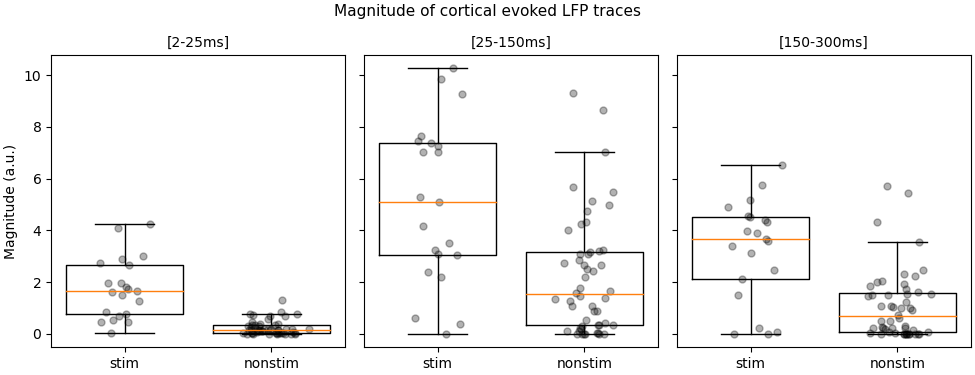

In [33]:
plot_depth = None # superficial, deep, or None=all combined
plot_state = 'awake'
plot_level = 'medium'

ctx_stim = {'stim': True, 'nonstim': False}

fig, axs = plt.subplots(1, 3, figsize=(9.75,3.75), sharex=True, sharey=True, constrained_layout=True)
for ax, windi in zip(axs, response_window.keys()):
    for ii, (labeli, stimTF) in enumerate(ctx_stim.items()):
        if plot_depth:
            df = all_subs_stats_df[
                (all_subs_stats_df['stim_depth'] == plot_depth) &
                (all_subs_stats_df['state'] == plot_state) &
                (all_subs_stats_df['stim_cortex'] == stimTF) &
                (all_subs_stats_df['stim_level'] == plot_level) &
                (all_subs_stats_df['window'] == windi)
            ]
        else:
            df = all_subs_stats_df[
                (all_subs_stats_df['state'] == plot_state) &
                (all_subs_stats_df['stim_cortex'] == stimTF) &
                (all_subs_stats_df['stim_level'] == plot_level) &
                (all_subs_stats_df['window'] == windi)
            ]
        
        allsubs_auc = df['auc'].values
        xs = np.random.normal(ii, 0.1, len(allsubs_auc))
        ax.boxplot(allsubs_auc, positions=[ii], widths=[0.8], showfliers=False)
        ax.scatter(xs, allsubs_auc, c='k', marker='o', s=25, alpha=0.3)
    ax.set_title('[{:d}-{:d}ms]'.format(int(response_window[windi][0]*1E3), int(response_window[windi][1]*1E3)))
axs[0].set_xticks([0,1])
axs[0].set_xticklabels(list(ctx_stim.keys()))
axs[0].set_ylabel('Magnitude (a.u.)')

plt.suptitle('Magnitude of cortical evoked LFP traces', fontsize=11)
## Save ##
figname = 'allresponses_allmice_stim-nonstim_LFP_{}.png'.format(date.today().strftime('%b%d%Y'))
# fig.savefig(os.path.join(plotsdir, figname), transparent=False)